In [2]:
library(tidyverse) 
library(tidymodels) 
library(ggpubr) 
library(e1071) 
library(corrplot) 
library(conflicted) 


tidymodels_prefer()
conflict_prefer("spec", "yardstick")
conflict_prefer("tune", "tune")

[conflicted] Will prefer yardstick::spec over any other package

[conflicted] Removing existing preference

[conflicted] Will prefer tune::tune over any other package



In [3]:
heart_df0 <- read_csv("https://raw.githubusercontent.com/benvictoria17/MachineLearning/master/dataset/heart_failure_clinical_records_dataset.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  age = col_double(),
  anaemia = col_double(),
  creatinine_phosphokinase = col_double(),
  diabetes = col_double(),
  ejection_fraction = col_double(),
  high_blood_pressure = col_double(),
  platelets = col_double(),
  serum_creatinine = col_double(),
  serum_sodium = col_double(),
  sex = col_double(),
  smoking = col_double(),
  time = col_double(),
  DEATH_EVENT = col_double()
)




In [5]:
glimpse(heart_df0)

Rows: 299
Columns: 13
$ age                      <dbl> 75, 55, 65, 50, 65, 90, 75, 60, 65, 80, 75, 6…
$ anaemia                  <dbl> 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, …
$ creatinine_phosphokinase <dbl> 582, 7861, 146, 111, 160, 47, 246, 315, 157, …
$ diabetes                 <dbl> 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, …
$ ejection_fraction        <dbl> 20, 38, 20, 20, 20, 40, 15, 60, 65, 35, 38, 2…
$ high_blood_pressure      <dbl> 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, …
$ platelets                <dbl> 265000, 263358, 162000, 210000, 327000, 20400…
$ serum_creatinine         <dbl> 1.90, 1.10, 1.30, 1.90, 2.70, 2.10, 1.20, 1.1…
$ serum_sodium             <dbl> 130, 136, 129, 137, 116, 132, 137, 131, 138, …
$ sex                      <dbl> 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, …
$ smoking                  <dbl> 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, …
$ time                     <dbl> 4, 6, 7, 7, 8, 8, 10, 10, 10, 10, 10, 10, 11,…
$ DEATH_EVENT     

In [6]:
head(heart_df0)

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
65,0,146,0,20,0,162000,1.3,129,1,1,7,1
50,1,111,0,20,0,210000,1.9,137,1,0,7,1
65,1,160,1,20,0,327000,2.7,116,0,0,8,1
90,1,47,0,40,1,204000,2.1,132,1,1,8,1


In [ ]:
map_df(((heart_df0, ~sum(is.na(.x))))))

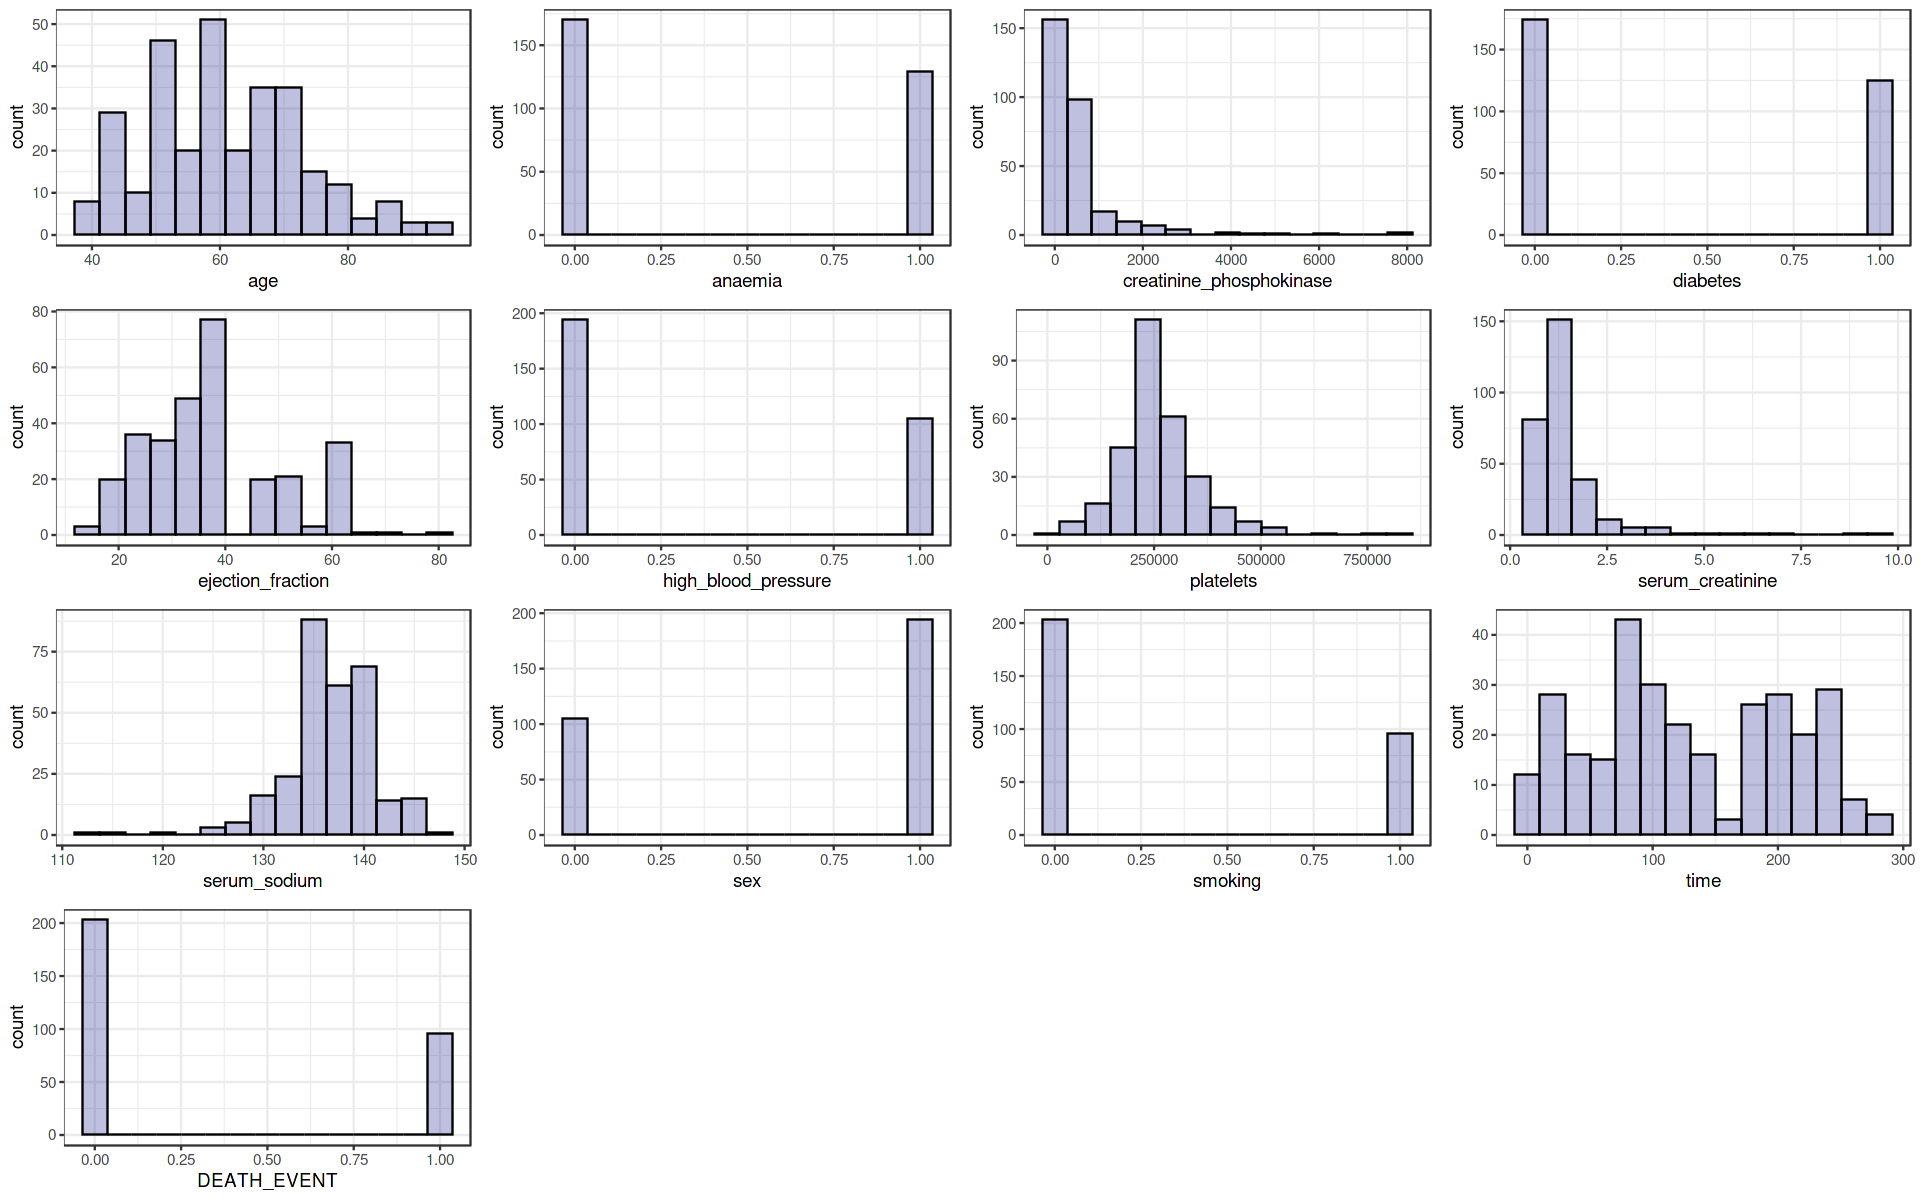

In [7]:
# set the plot size
options(repr.plot.width=16, repr.plot.height=10)

# use map to create a list of plots
rawdata_plots_list <- map2(.x = heart_df0, .y = names(heart_df0), .f = ~ggplot(heart_df0, aes(x = .x)) +
     geom_histogram(fill = "navy", col = "black", alpha = 0.25, bins = 15) +
     labs(x = .y) +
     theme_bw())

# display all the plots together
ggpubr::ggarrange(plotlist = rawdata_plots_list)

In [8]:
bool_cols <- c("anaemia", "diabetes", "high_blood_pressure", "smoking", "DEATH_EVENT")

# convert the boolean columns to logical
# make sex a factor (categorical) variable
# make the column names lowercase (only applies to DEATH_EVENT)
heart_df <- heart_df0 %>%
  mutate(across(.cols = all_of(bool_cols), .fns = ~as.logical(.x)),
         sex = factor(if_else(sex == 0, "female", "male"),
                      levels = c("female", "male"))) %>%
  rename_with(~str_to_lower(.x))

head(heart_df)

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
<dbl>,<lgl>,<dbl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>,<dbl>,<lgl>
75,FALSE,582,FALSE,20,TRUE,265000,1.9,130,male,FALSE,4,TRUE
55,FALSE,7861,FALSE,38,FALSE,263358,1.1,136,male,FALSE,6,TRUE
65,FALSE,146,FALSE,20,FALSE,162000,1.3,129,male,TRUE,7,TRUE
50,TRUE,111,FALSE,20,FALSE,210000,1.9,137,male,FALSE,7,TRUE
65,TRUE,160,TRUE,20,FALSE,327000,2.7,116,female,FALSE,8,TRUE
90,TRUE,47,FALSE,40,TRUE,204000,2.1,132,male,TRUE,8,TRUE


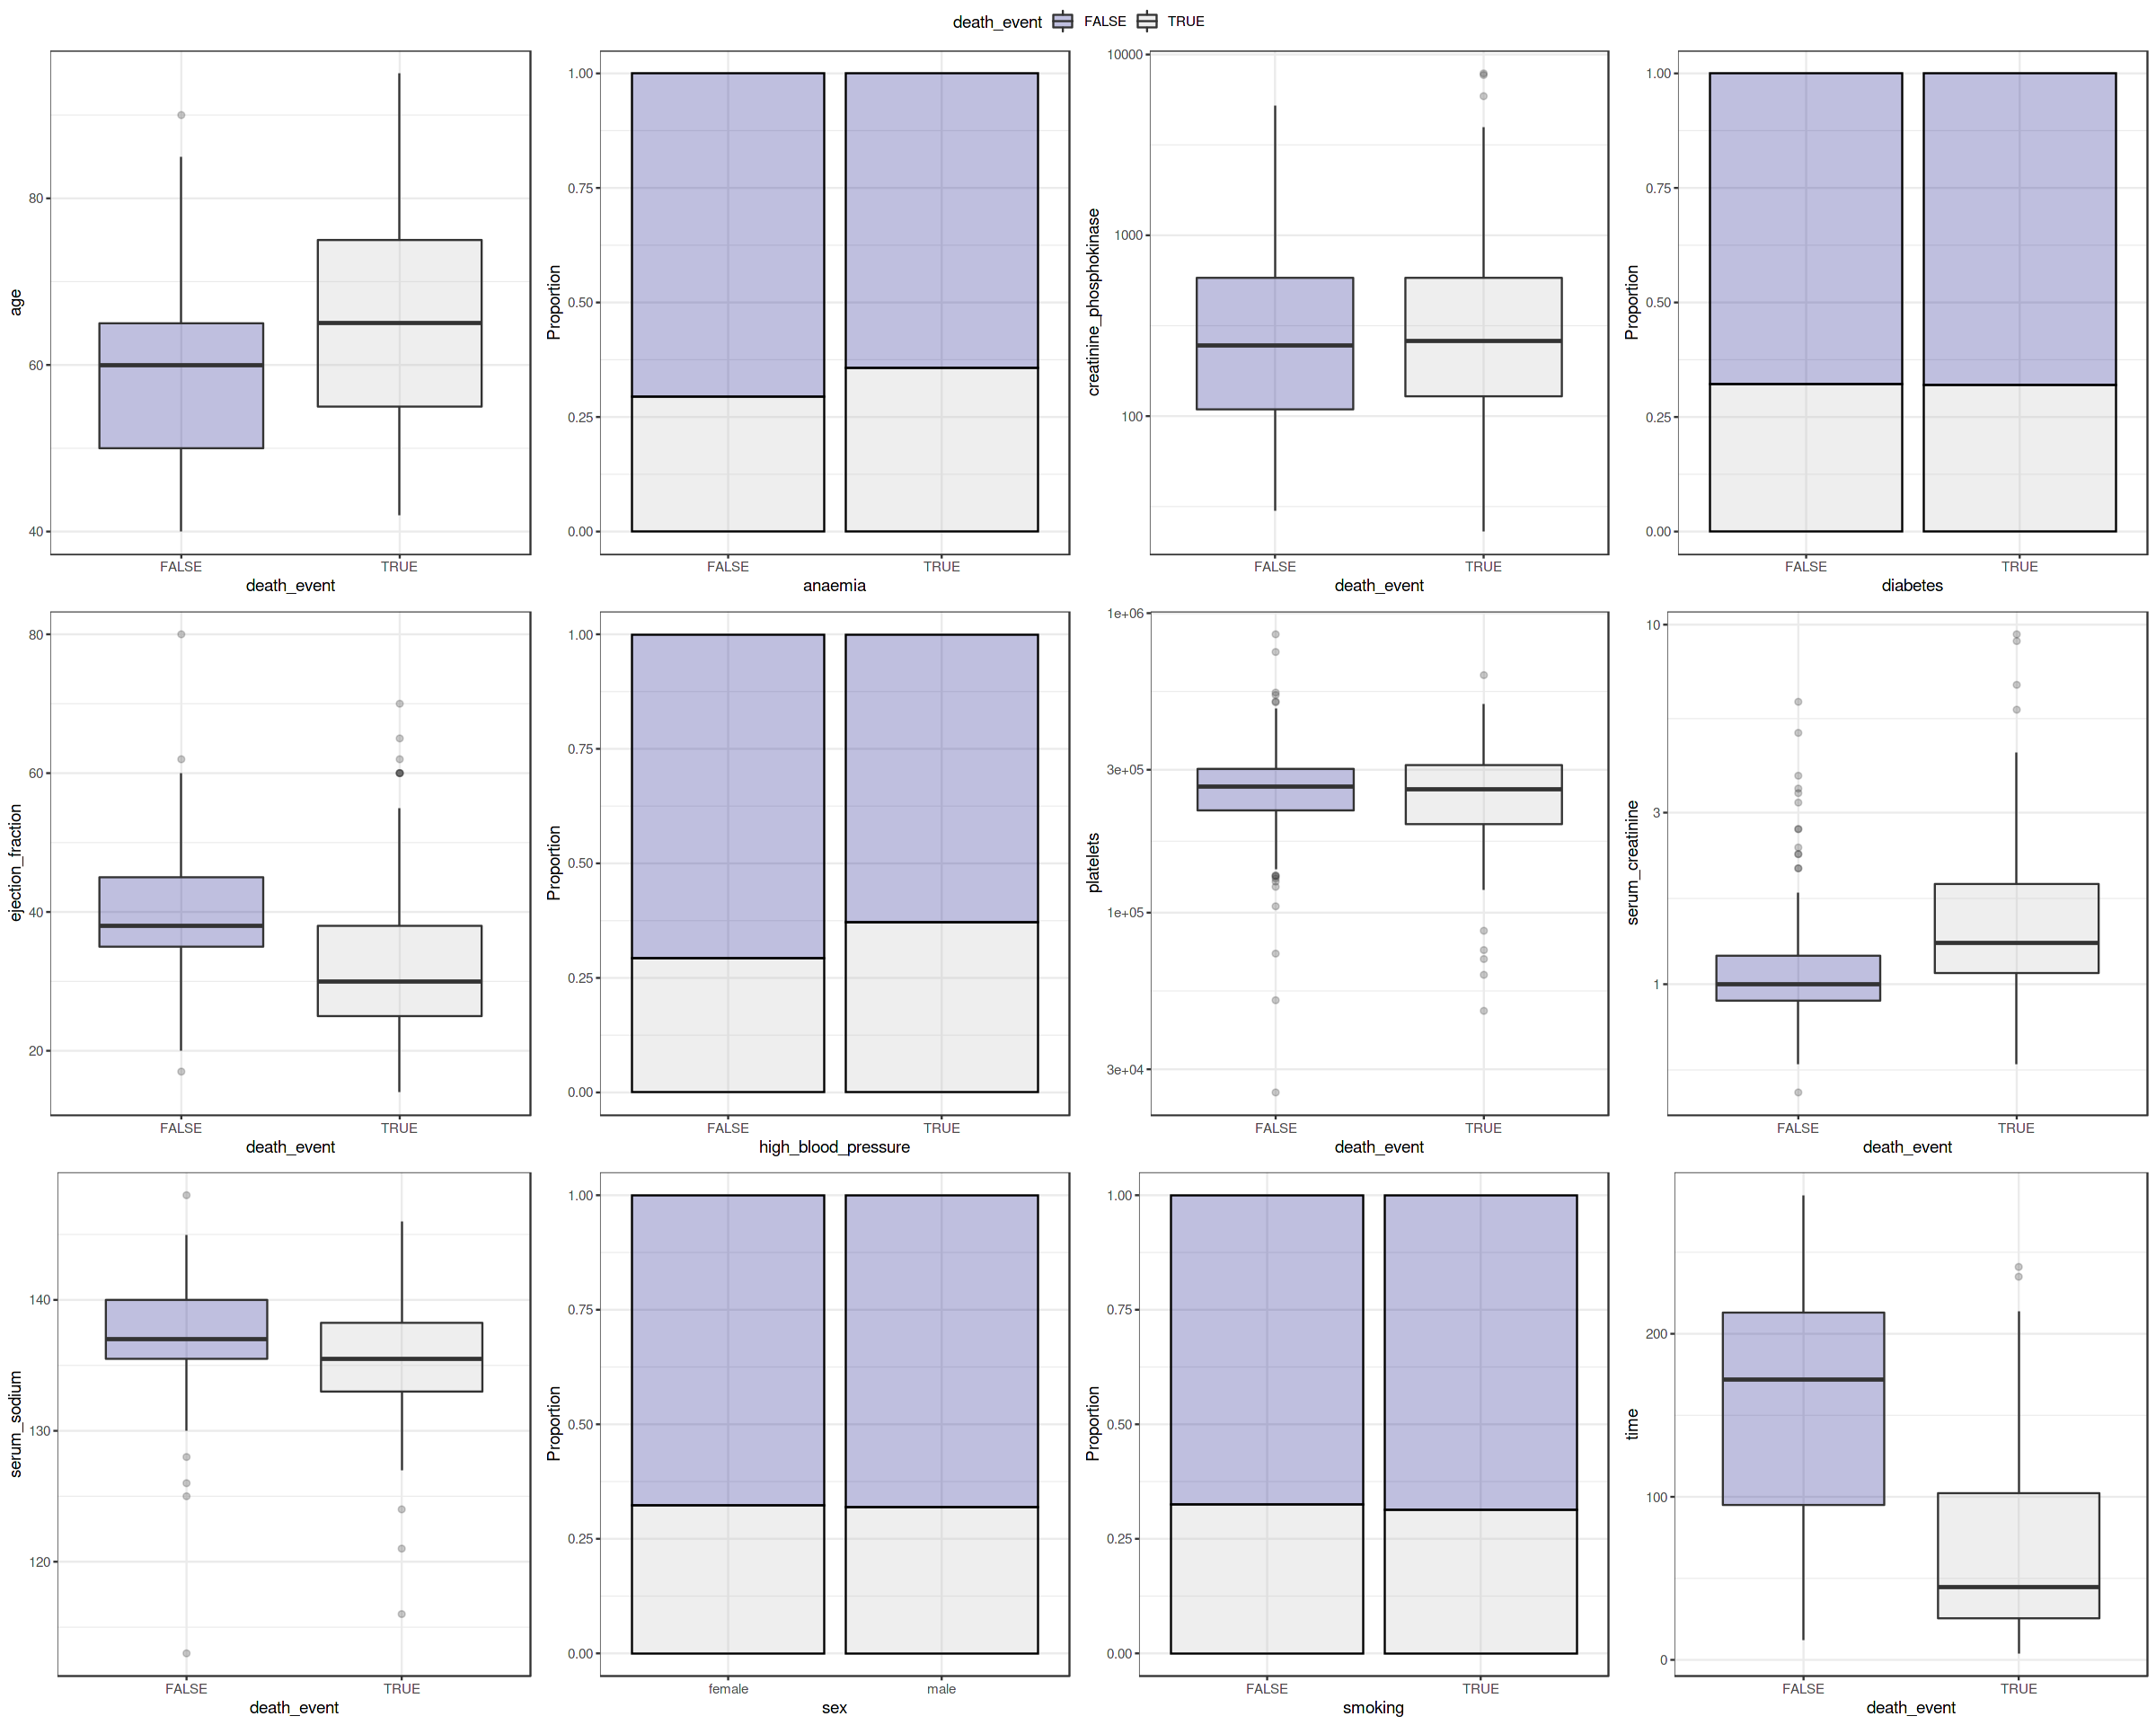

In [9]:

make_plot <- function(data, predictor, outcome){
    # create the plot object and aesthetics
    g <- data %>% ggplot()
    # check to see if the feature is numeric
    if(data %>% pull(predictor) %>% class == "numeric"){
        # make a boxplot for numeric feature
        g <- g + geom_boxplot(aes_string(x = outcome, y = predictor, fill = outcome), alpha = 0.25)
        # if the data is sufficiently skewed, log transform the axis
        if(skewness(data %>% pull(predictor)) > 0.75) {
            g <- g + scale_y_log10()
        }
    } else {
        # if the feature is not numeric, make a bar plot
        g <- g + geom_bar(aes_string(x = predictor, fill = outcome), col = "black", alpha = 0.25, position = "fill") +
          labs(y = "Proportion")
    }
    # set the colors and change the plot theme
    g <- g +
    scale_fill_manual(values = c("navy", "gray")) +
    theme_bw()
    
    # return the plot
    g
}
# set the plot size
options(repr.plot.width=20, repr.plot.height=16)

# use map to create a list of plots for each predictor variable
cleandata_plots_list <- map(names(heart_df)[1:12], ~make_plot(data = heart_df, predictor = .x, outcome = "death_event"))

# display the plots
ggarrange(plotlist = cleandata_plots_list, common.legend = TRUE)

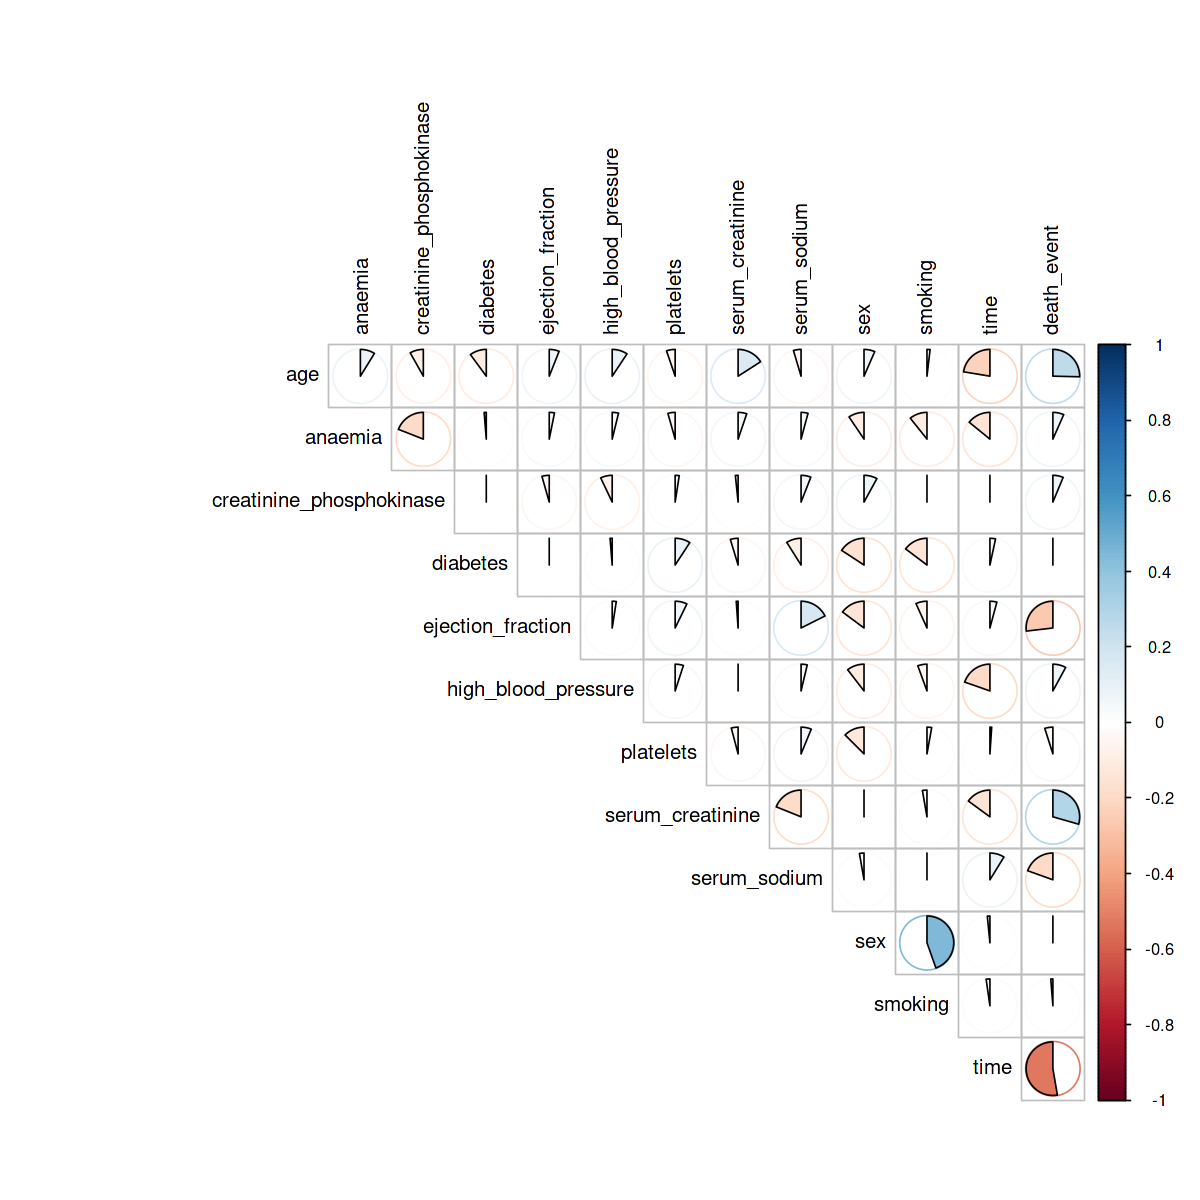

In [10]:
# set the plot size
options(repr.plot.width=10, repr.plot.height=10)

# create correlation plot
# (we need to convert the booleans and factor variables to numeric before we can feed the data frame into corrplot)
corrplot(cor(heart_df %>% mutate(across(everything(), ~as.numeric(.x)))),
         method = "pie", type = "upper", tl.col = "black", diag = FALSE)

In [11]:
heart_model_df <- heart_df %>%
  select(-time) %>%
  mutate(across(.cols = where(is.logical), .fns = ~ str_to_lower(.x) %>% as.factor()),
         death_event = fct_rev(death_event))

head(heart_model_df)

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,death_event
<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
75,false,582,false,20,true,265000,1.9,130,male,false,true
55,false,7861,false,38,false,263358,1.1,136,male,false,true
65,false,146,false,20,false,162000,1.3,129,male,true,true
50,true,111,false,20,false,210000,1.9,137,male,false,true
65,true,160,true,20,false,327000,2.7,116,female,false,true
90,true,47,false,40,true,204000,2.1,132,male,true,true


In [12]:
set.seed(815) # for reproducibility
heart_split <- heart_model_df %>% initial_split(prop = 0.75, strata = death_event)

heart_train <- heart_split %>% training()
heart_test <- heart_split %>% testing()
# specify cross validation sets
set.seed(1321)
heart_folds <- vfold_cv(heart_train, v = 10, strata = death_event)

In [13]:
heart_rec <- recipe(death_event ~ ., data = heart_train) %>%
  step_log(creatinine_phosphokinase, serum_creatinine, platelets, base = 10) %>%
  step_normalize(all_numeric()) %>%
  step_dummy(all_nominal(), -all_outcomes())

heart_rec

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         11

Operations:

Log transformation on creatinine_phosphokinase, ...
Centering and scaling for all_numeric()
Dummy variables from all_nominal(), -all_outcomes()

In [14]:

lgr_model <- logistic_reg() %>%
  set_engine('glm') %>%
  set_mode('classification')

# decision tree
dt_model <- decision_tree() %>%
  set_engine('rpart') %>%
  set_mode('classification')

# polynomial support vector machine
psvm_model <- svm_poly() %>%
  set_engine('kernlab') %>%
  set_mode('classification')

# random forest
rf_model <- rand_forest() %>%
  set_engine('ranger') %>%
  set_mode('classification')

# boosted trees
bt_model <- boost_tree() %>%
  set_engine('xgboost') %>%
  set_mode('classification')

# store the list of model engines and names (this will be used with the map function later)
model_list <- list(lgr_model, dt_model, psvm_model, rf_model, bt_model)
model_names <- c("logistic regression", "decision tree", "polynomial SVM", "random forest", "boosted trees")

In [15]:
heart_metrics <- metric_set(accuracy, sens, spec, roc_auc)

In [16]:

lgr_fit <- workflow() %>%
  add_model(lgr_model) %>%
  add_recipe(heart_rec) %>%
  fit_resamples(resamples = heart_folds,
                metrics = heart_metrics)

# logistic regression metrics
lgr_fit_metrics <- lgr_fit %>%
  collect_metrics(summarize = FALSE) %>%
  group_by(.metric) %>%
  summarize(mean_est = mean(.estimate),
            min_est = min(.estimate),
            max_est = max(.estimate)) %>%
  mutate(model = "logistic regression")

lgr_fit_metrics

.metric,mean_est,min_est,max_est,model
<chr>,<dbl>,<dbl>,<dbl>,<chr>
accuracy,0.7454545,0.5909091,0.8636364,logistic regression
roc_auc,0.7472842,0.5047619,0.9218750,logistic regression
sens,0.5089286,0.2857143,0.8750000,logistic regression
spec,0.8562500,0.7333333,1.0000000,logistic regression


In [17]:

set.seed(42)
all_models <- map(
  .x = model_list,
  .f = ~ workflow() %>%
         add_model(.x) %>%
         add_recipe(heart_rec) %>%
         fit_resamples(resamples = heart_folds, metrics = heart_metrics)) %>% setNames(model_names)

all_metrics <- map_dfr(
  .x = all_models,
  .f = ~.x %>% collect_metrics(summarize = FALSE), .id = "model")

glimpse(all_metrics)

Rows: 200
Columns: 6
$ model      <chr> "logistic regression", "logistic regression", "logistic reg…
$ id         <chr> "Fold01", "Fold01", "Fold01", "Fold01", "Fold02", "Fold02",…
$ .metric    <chr> "accuracy", "sens", "spec", "roc_auc", "accuracy", "sens", …
$ .estimator <chr> "binary", "binary", "binary", "binary", "binary", "binary",…
$ .estimate  <dbl> 0.6666667, 0.5000000, 0.7500000, 0.7890625, 0.8333333, 0.87…
$ .config    <chr> "Preprocessor1_Model1", "Preprocessor1_Model1", "Preprocess…


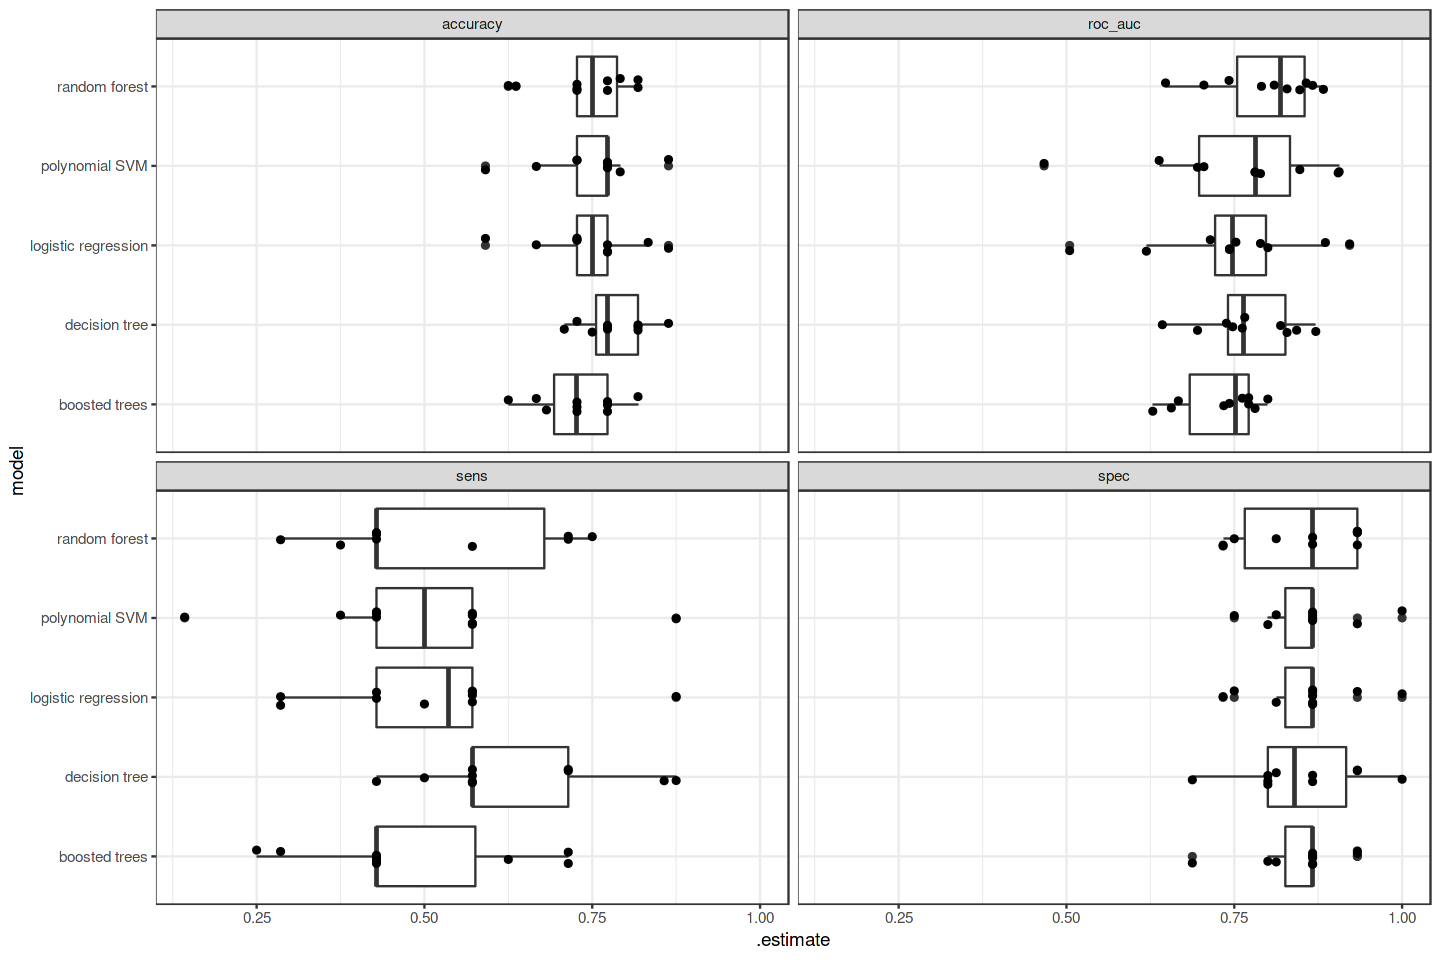

In [18]:
options(repr.plot.width=12, repr.plot.height=8)

# create a plot to show cross validation model performance across our chosen metrics
all_metrics %>%
  ggplot(aes(x = .estimate, y = model)) +
  geom_boxplot() +
  geom_jitter(width = 0, height = 0.1) +
  facet_wrap(facets = vars(.metric)) +
  theme_bw()

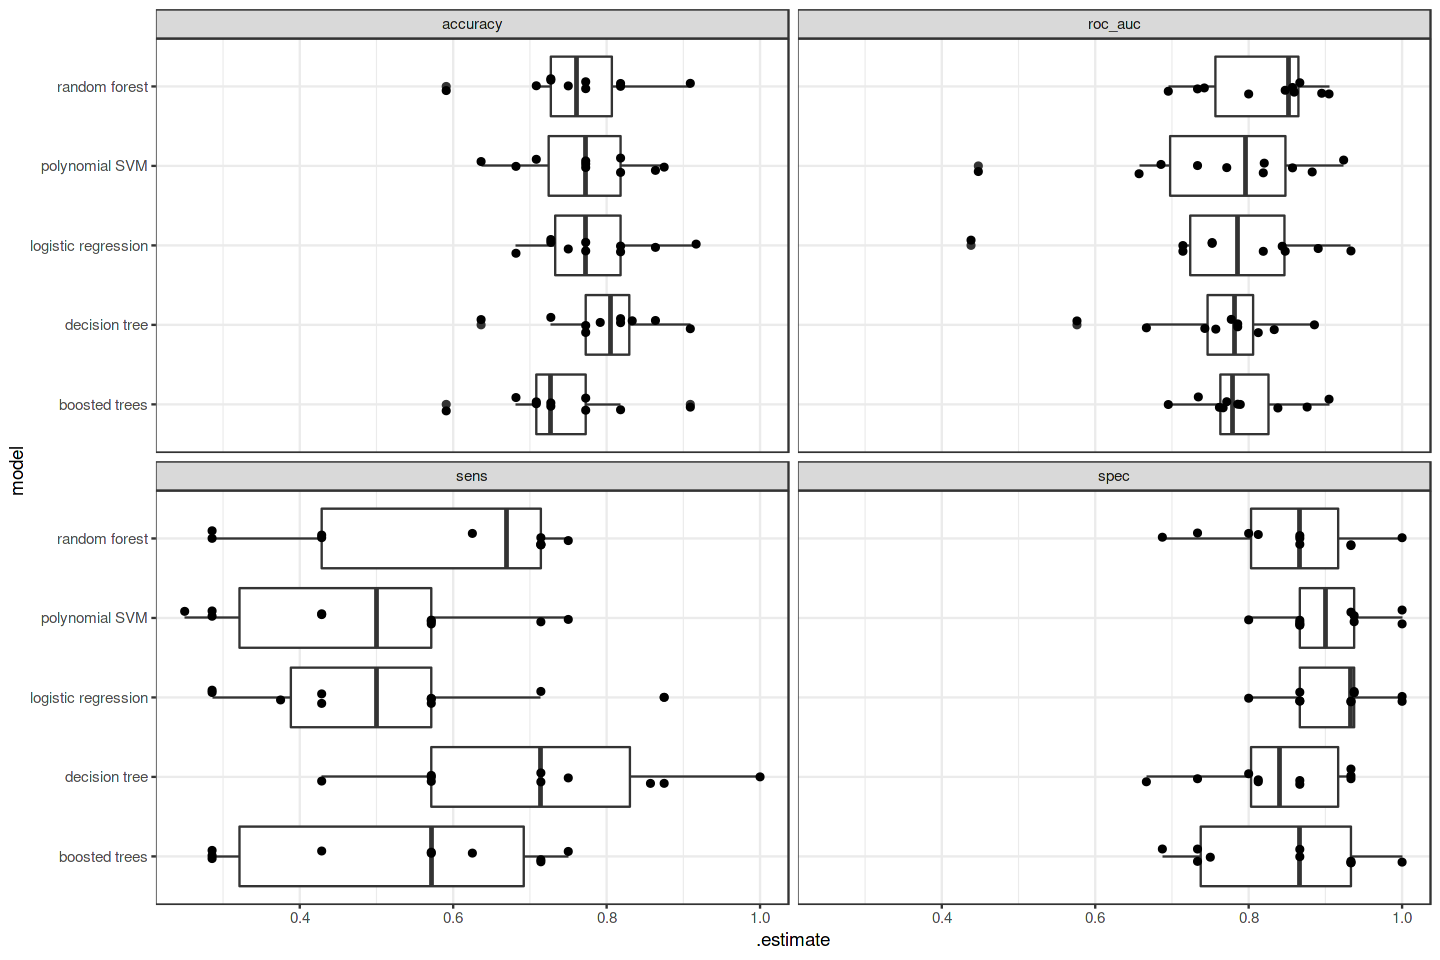

In [19]:

options(repr.plot.width=12, repr.plot.height=8)

# define the new recipe
new_recipe <- recipe(death_event ~ age + serum_creatinine + ejection_fraction, data = heart_train) %>%
  step_log(serum_creatinine, base = 10) %>%
  step_normalize(all_numeric())

# add the new recipe to the workflow
set.seed(1650)
new_models <- map(
  .x = model_list,
  .f = ~ workflow() %>%
         add_model(.x) %>%
         add_recipe(new_recipe) %>%
         fit_resamples(resamples = heart_folds, metrics = heart_metrics)) %>% setNames(model_names)

# collect metrics from all the models
new_metrics <- map_dfr(
  .x = new_models,
  .f = ~.x %>% collect_metrics(summarize = FALSE), .id = "model")

# create a plot to show cross validation model performance across our chosen metrics
new_metrics %>%
  ggplot(aes(x = .estimate, y = model)) +
  geom_boxplot() +
  geom_jitter(width = 0, height = 0.1) +
  facet_wrap(facets = vars(.metric)) +
  theme_bw()

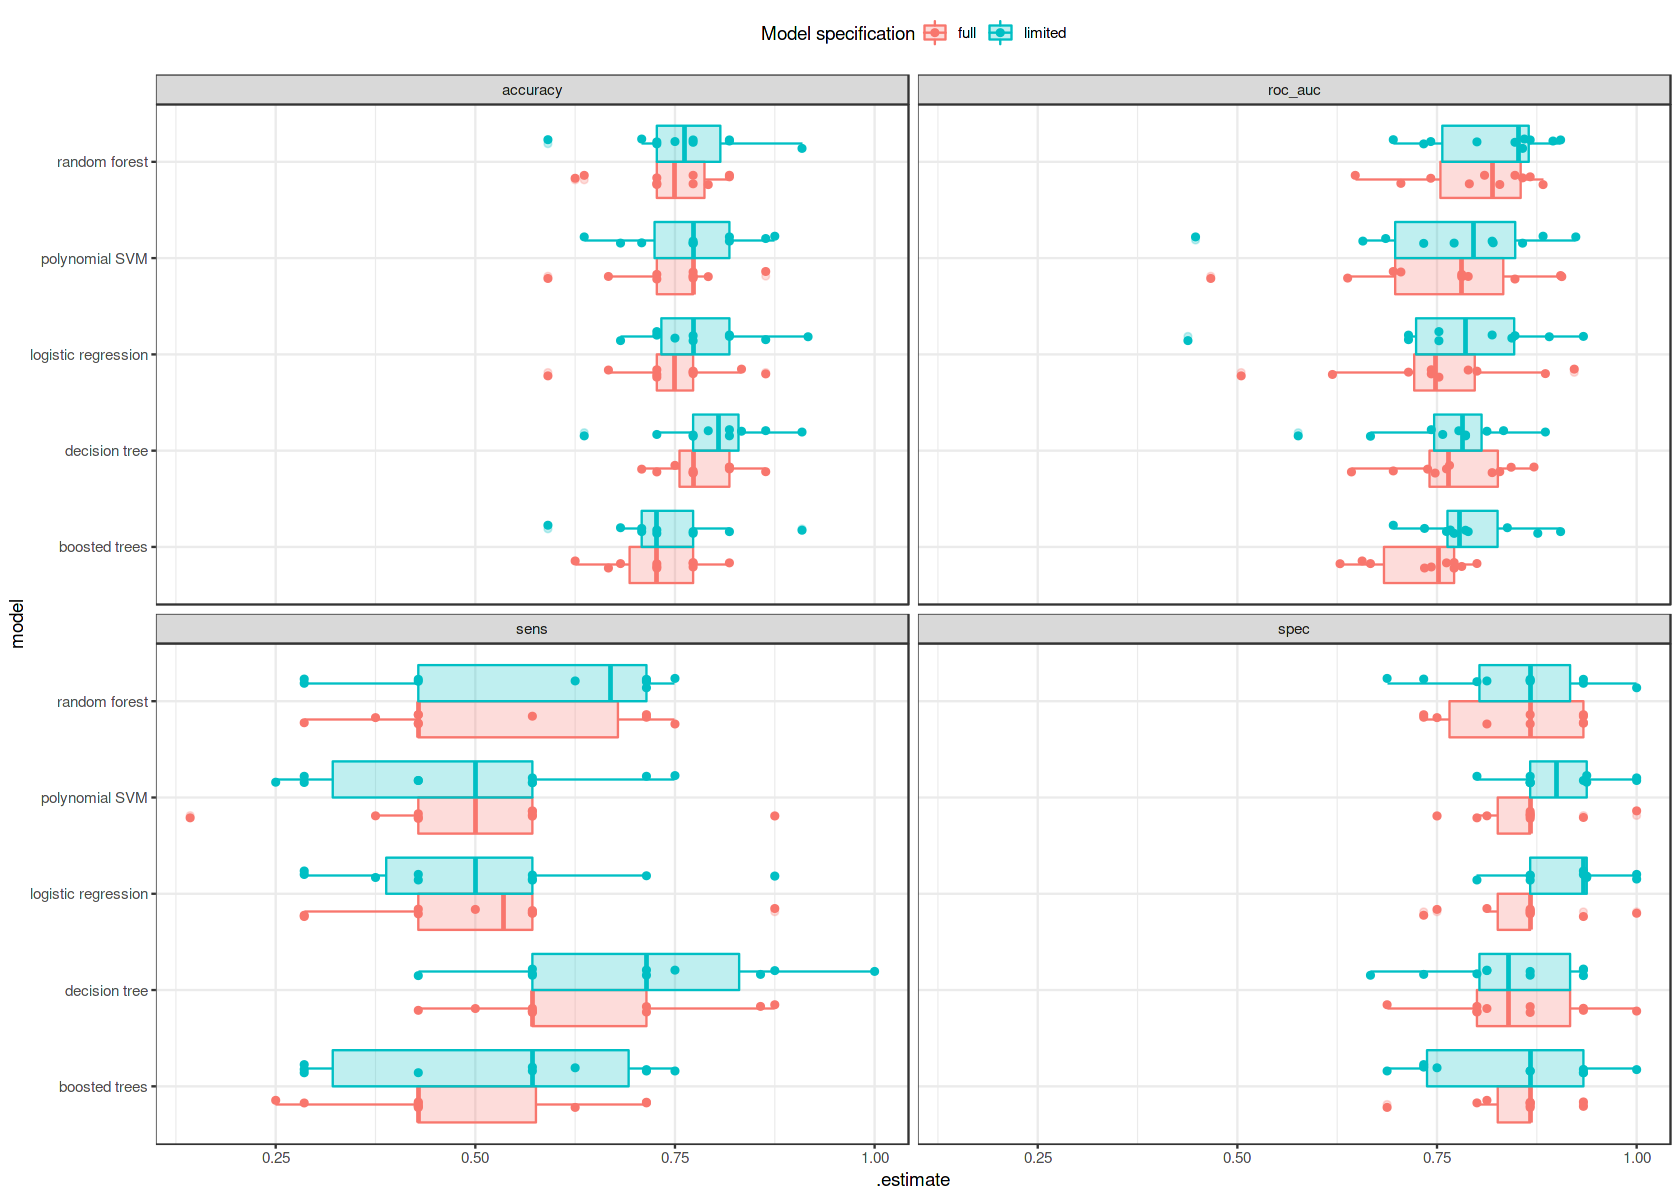

In [21]:

options(repr.plot.width=14, repr.plot.height=10)

# combine the dataframe of metrics from the two types of models
comb_metrics <- bind_rows(all_metrics %>% mutate(rec = "full"),
                          new_metrics %>% mutate(rec = "limited"))

# create a comparison plot
comb_metrics %>%
  ggplot(aes(x = .estimate, y = model, fill = rec, col = rec)) +
  geom_boxplot(alpha = 0.25, position = "dodge") +
  geom_point(position = position_jitterdodge(jitter.height=0, jitter.width=0.1)) +
  facet_wrap(facets = vars(.metric)) +
  labs(col = "Model specification", fill = "Model specification") +
  theme_bw() +
  theme(legend.position = "top")